# Using the image cutout tool with DP0.2

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact author: Christina Williams <br>
Last verified to run: 2024-10-29 <br>
LSST Science Piplines version: Weekly 2024_42 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** This notebook demonstrates how to use the Rubin Image Cutout Service.

**Skills:** Run the Rubin Image Cutout Service for visual inspection of small cutouts of LSST images.

**LSST Data Products:** Images (deepCoadd, calexp), catalogs (objectTable, diaObject, truthTables, ivoa.ObsCore).

**Packages:** PyVO, lsst.rsp.get_tap_service, lsst.pipe.tasks.registerImage, lsst.afw.display

**Credit:**
This notebook builds on technical exploration of the cutout service developed by Leanne Guy (in preparation), and builds on an earlier notebook written by Alex Drlica-Wagner <a href="https://github.com/rubin-dp0/cst-dev/blob/main/ADW_gravelpit/TAP_Image_Access.ipynb">linked here</a>. This notebook additionally includes contributed functions by Jeff Carlin and Ryan Lau for time-variable sources. 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach how to use the cutout service (which enables users to retrieve small image cutouts from LSST data) by demonstration of a few basic science applications. Since LSST images are quite large, in some cases it is desirable to be able to perform image cutouts on the server side to avoid transferring large amounts of data. This can speed up visual inspection and other analyses requiring images of individual objects or fields that may be much smaller than the patch and tract sizes that are created by the LSST camera and pipelines.

The <a href="https://www.ivoa.net/">International Virtual Observatory Alliance (IVOA)</a> co-ordinates the community efforts of astronomical missions and archives to develop and maintain the Virtual Observatory (VO) standards. The VO standards enable interoperability between astronomical archives. IVOA also provides a <a href="https://www.ivoa.net/documents/SODA/20170517/REC-SODA-1.0.html">Server-side Operations for Data Access (SODA)</a>, which is a protocol for remote data processing operations. This protocol allows users to perform computations (pixel operations, image transformations, etc) on the remote server, which avoids unnecssary data movement. The LSST architecture has a "VO-first" approach, meaning that VO standards are implemented in all applicable services, enabling the use of VO tools such as the image cutout service to access LSST data. The procedure is to identify the remote web location of the image of interest (called a datalink), and use a web service that creates a cutout from that linked data remotely, to transfer and save locally on the Rubin Science Platform.

Further details and information can be found at <a href="https://www.ivoa.net/documents/DataLink/20211115/WD-DataLink-1.1-20211115.html"> the IVOA data link documentation</a>, where it says Access Data Services. Rubin-specific documentation for these can also be found in <a href="https://dmtn-238.lsst.io/">this document describing the RSP DataLink service implementation strategy</a>. 



### 1.1 Package Imports

Import general python packages, LSST packages, PyVO packages, and Astropy packages.

In [1]:
import time
import numpy as np
import uuid
import os
import glob
import math
import pandas
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as dimg

import lsst.geom as geom
import lsst.resources
import lsst.afw.display as afwDisplay
from lsst.afw.image import Exposure, ExposureF
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask
from lsst.rsp import get_tap_service
from lsst.rsp.utils import get_access_token
from lsst.afw.fits import MemFileManager

import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy.wcs import WCS

### 1.2 Define Functions and Parameters

Set the backend for `afwDisplay` to `matplotlib`.
Set parameters for plots.

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

params = {'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 12,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 10,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 2,
          'axes.titleweight': 2,
          'ytick.major.width': 2,
          'ytick.minor.width': 1,
          'ytick.major.size': 10,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }
plt.style.use('tableau-colorblind10')

plt.rcParams.update(params)

When displaying `pandas` tables in the notebook,
only display up to 20 rows.

In [3]:
pandas.set_option('display.max_rows', 20)

The Rubin cutout service allows the user to save cutouts as fits files locally on the Rubin Science Platform (RSP).
Create a new temporary folder in the home directory called "temp" in which to save these files.
At the end of the notebook, the last cell will clear the contents and remove the temp folder.

In [4]:
tempdir = 'dp02_13a_temp'
temppath = os.getenv("HOME") + '/' + tempdir
if not os.path.exists(temppath):
    os.makedirs(temppath)
    print('Created: ', temppath)
else:
    print('Already exists: ', temppath)
del temppath

Already exists:  /home/christinawilliams/dp02_13a_temp


The following cells define a number of functions to be used throughout the tutorial. The first function is to enable easy plotting of files from the cutout tool (`plotImage`). The next function, `make_image_cutout`, is a wrapper function that will perform the operations needed to call the cutout tool and create image cutouts stored locally. This procedure will first be demonstrated in Section 2. The steps include: 1) define the location on the sky. 2) Query the TAP service for the specifications of the dataId. 3) Retrieve the datalink URL associated with the data. 4) Create a cutout instance from the query result and the Datalink Resource.

In [5]:
def plotImage(exposure: ExposureF):
    """Plot and image using lsst.awf.image package

   Parameters
    ----------
    exposure : `ExposureF`
        the image to plot from file in LSST awf image exposure class format

   Returns
    -------
    image for notebook display
    """

    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()

In [6]:
def make_image_cutout(tap_service, ra, dec, dataId, cutout_size=0.01,
                      imtype=None, filename=None):
    """Wrapper function to generate a cutout using the cutout tool

   Parameters
    ----------
    tap_service : an instance of the TAP service
    ra, dec : 'float'
        the ra and dec of the cutout center
    dataId : 'dict'
        the dataId of the image to make a cutout from. The format
        must correspond to that provided for parameter 'imtype'
    cutout_size : 'float', optional
        edge length in degrees of the cutout
    imtype : 'string', optional
        string containing the type of LSST image to generate
        a cutout of (e.g. deepCoadd, calexp). If imtype=None,
        the function will assume a deepCoadd.
    filename : 'string', optional
        filename of the resulting cutout (which has fits format)

   Returns
    -------
    sodaCutout : 'string'
        filename of the cutout in fits format (including
        full directory path; for now by default it is saved
        in /home/dp02_13a_temp/
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

    if imtype == 'calexp':

        query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_visit, lsst_detector, lsst_band " + \
            "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.calexp' " + \
            "AND lsst_visit = " + str(dataId["visit"]) + " " + \
            "AND lsst_detector = " + str(dataId["detector"])
        results = tap_service.search(query)

    else:
        # Find the tract and patch that contain this point
        tract = dataId["tract"]
        patch = dataId["patch"]

        # add optional default band if it is not contained in the dataId
        band = dataId["band"]

        query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_patch, lsst_tract, lsst_band " + \
            "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_tract = " + str(tract) + " " + \
            "AND lsst_patch = " + str(patch) + " " + \
            "AND lsst_band = " + "'" + str(band) + "' "
        results = tap_service.search(query)

    # Get datalink
    dataLinkUrl = results[0].getdataurl()
    auth_session = service._session
    dl = DatalinkResults.from_result_url(dataLinkUrl,
                                         session=auth_session)

    # from_resource: creates a instance from
    # a number of records and a Datalink Resource.
    sq = SodaQuery.from_resource(dl,
                                 dl.get_adhocservice_by_id("cutout-sync"),
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
                 spherePoint.getDec().asDegrees() * u.deg,
                 cutout_size * u.deg)

    if filename:
        sodaCutout = os.path.join(os.getenv('HOME'), 'dp02_13a_temp/'+filename)
    else:
        sodaCutout = os.path.join(os.getenv('HOME'), 'dp02_13a_temp/soda-cutout.fits')

    with open(sodaCutout, 'bw') as f:
        f.write(sq.execute_stream().read())

    return sodaCutout

Finally, this third cell below defines a set of functions that we will use to work with cutouts of the same source to demonstrate how to visualize variability between calexp files, for diaObjects. Since calexp files may be imaged at any orientation on the sky, in order to align the images the user will 1) rotate and scale the image to a common grid (`warp_image`) and 2) determine the bounding box of the cutouts (`get_minmax_xy`) and 3) create a gif of those warped images to visualize the variability of the source (`make_gif`). These will be demonstrated in Section 4.

In [7]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):
    """Warp and rotate an image onto the coordinate system of another image

   Parameters
    ----------
    ref_img: 'ExposureF'
        is the reference image for the re-projection
    img_to_warp: 'ExposureF'
        the image to rotate and warp onto the reference image's wcs
    ref_wcs: 'wcs object'
        the wcs of the reference image (i.e. ref_img.getWcs() )
    wcs_to_warp: 'wcs object'
        the wcs of the image to warp (i.e. img_to_warp.getWcs() )
   Returns
    -------
    warpedExp: 'ExposureF'
        a reprojected, rotated image that is aligned and matched to ref_image
     """
    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp


def get_minmax_xy(img, cutout_size):
    """Get the pixel dimensions of an image

   Parameters
    ----------
    img: 'ExposureF'
        is the input image to return the pixel coordinates of
    cutout_size: 'int'
        is the edge size of the image in pixels
   Returns
    -------
    minx, maxx, miny, maxy: 'int'
        the min and max x and y pixel coordinates for the input image
     """

    cutout_size = int(cutout_size)

    height = img.height
    width = img.width

    ceny = (height - 1) / 2
    cenx = (width - 1) / 2

    minx = int(cenx - ((cutout_size - 1) / 2))
    maxx = int(cenx + ((cutout_size - 1) / 2))
    miny = int(ceny - ((cutout_size - 1) / 2))
    maxy = int(ceny + ((cutout_size - 1) / 2))

    return {'minx': minx, 'maxx': maxx, 'miny': miny, 'maxy': maxy}


def make_gif(folder):
    """Generate a GIF for all *.png images contained in a folder

   Parameters
    ----------
    # folder: 'string'
        string containing the path to the folder
        default filename is animation.gif

   Returns
    -------
     """
    frames = [Image.open(img) for img in sorted(glob.glob(f"{folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(folder+"/animation.gif", format="GIF",
                   append_images=frames, save_all=True, duration=500, loop=1)


## 2. A step by step demonstration of how to use the Rubin Image Cutout Service

This section will demonstrate a simple example: how to create a cutout for a single part of sky from a deepCoadd. 


### 2.1 Initiate the TAP service, and define sky coordinates for the image cutout

The TAP service is used to query the ivoa.Obscore table for the datalink (a web URL identifying where the data is hosted).

In [8]:
service = get_tap_service("tap")

First, define a point on the sky as the center of the image cutout. This example uses the galaxy cluster from DP0.2 Notebook Tutorial 03a. Once the RA and Dec are defined, the cell also creates a SpherePoint class to define the location on the sky. These will be used in a TAP query to identify the overlapping deepCoadd image.  

In [9]:
ra = 55.7467
dec = -32.2862
coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
radius = .1 * u.deg

spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)


The next cell shows the TAP query for the metadata that is associated with the image's remote location in the LSST data archive. The DP0.2 has a schema (table collection) called "ivoa", which contains a table called ivoa.ObsCore. The IVOA-defined obscore table contains generic metadata for the DP0.2 datasets. The table is accessible via ADQL queries via a TAP endpoint. The mechanism for locating the images LSST is to use the TAP service to query the ObsCore schema. 

In [10]:
query = "SELECT lsst_patch, lsst_tract, s_region, " + \
        "access_format, access_url, dataproduct_subtype " + \
        "FROM ivoa.ObsCore " + \
        "WHERE dataproduct_type = 'image' " + \
        "AND obs_collection = 'LSST.DP02' " + \
        "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
        "AND lsst_band = 'i' " + \
        "AND CONTAINS(POINT('ICRS', " + str(coord.ra.value) + \
        ", " + str(coord.dec.value) + "), " + \
        "s_region) = 1"


In [11]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [12]:
results = job.fetch_result()

In [13]:
results.to_table()

lsst_patch,lsst_tract,s_region,access_format,access_url,dataproduct_subtype
int64,int64,str512,str128,object,str64
17,4431,POLYGON ICRS 55.514085 -32.322253 55.790197 -32.322253 55.789845 -32.088924 55.514437 -32.088924,application/x-votable+xml;content=datalink,https://data-int.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/20d28216-534a-4102-b8a7-1c7f32a9b78c,lsst.deepCoadd_calexp


In the above table, the `access_url` contains the web URL datalink for the requested deepCoadd. This datalink will be needed to generate the image cutout.

The identified Patch and Tract will be used to define the unique dataId for that location, and once a filter (band) is included, this defines a unique deepCoadd in the LSST image database. Below, construct the dataId.

In [14]:
tract = results['lsst_tract'][0]
patch = results['lsst_patch'][0]

dataId = {'band': 'i', 'tract': tract,
          'patch': patch}

### 2.2 Generating an image cutout 

First, extract the datalink (`dataLinkUrl`) from the query result using the `getdataurl` method. Next, extract the session authentication, which is needed for reuse of the datalink (see DP0.2 Tutorial 22a, which has further technical explanation). Finally, create a `DatalinkResults` object to be able to access this URL, which will be stored as `dl_results` and available for approximately 15 minutes, in a format that can be used by the IVOA tools below.


In [15]:
dataLinkUrl = results[0].getdataurl()

auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,
                                             session=auth_session)

f"Datalink status: {dl_results.status}. Datalink service url: {dataLinkUrl}"

"Datalink status: ('OK', 'QUERY_STATUS not specified'). Datalink service url: https://data-int.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/20d28216-534a-4102-b8a7-1c7f32a9b78c"

Lastly, call the Rubin Image Cutout Service. It is done by feeding the data link created above (called `dl_results`) to following function:

In [16]:
sq = SodaQuery.from_resource(dl_results,
                             dl_results.get_adhocservice_by_id("cutout-sync"),
                             session=auth_session)

The variable `sq` now holds the result of the SODA query using the data link (which currently still points the full LSST patch and tract deepCoadd image, at its remote location in the database). The cell below will now demonstrate how to extract a cutout from `sq`.  

### 2.2.1 Defining a square cutout using a subtended circle

Only 2 shape definitions are supported: a circle function, and a polygon function can be used to define the cutout dimensions. These shape definitions do not produce circle or polygon cutouts, but rather are methods for defining the edges of cutouts with 4 sides. In the case of circle, the resulting cutout is always a square, with edge size that is the same as the circle diameter. In the case of a polygon, either a square or a rectangular cutout will result, depending on whether the length and width edge dimensions are different values. Only cutouts with 4 corners and 90 degree angles are supported. 



In [17]:
sphereRadius = 0.05 * u.deg
sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
             spherePoint.getDec().asDegrees() * u.deg,
             sphereRadius)

### 2.2.2 Saving and plotting the cutout

This section will demonstrate two ways to handle the output of the cutout service. The next cell demonstrates how to create a fits file, stored in the returned Google cloud storage service (GCS) bucket. While the image cutout procedure itself is performed remotely, bytes are returned, and the user can decide how to receive it. In the following example, the cutout is written to disk as a fits file first (which is done using the write() function), before it is accessed by the notebook. (Future planned options for the Rubin cutout service, including the potential to retrieve other image formats such as jpeg, are listed at the <a href="https://dmtn-208.lsst.io/">Rubin Science Platform image cutout implementation strategy document</a>).

All cutouts saved to disk will be stored in the temporary folder in this notebook. 

In [18]:
sodaCutout = os.path.join(os.getenv('HOME'), tempdir + '/soda-cutout-circle.fits')
with open(sodaCutout, 'bw') as f:
    f.write(sq.execute_stream().read())

Finally, call the `plotImage` function (defined in Section 1), which will quickly display the cutout that was written to disk in in the temporary folder.

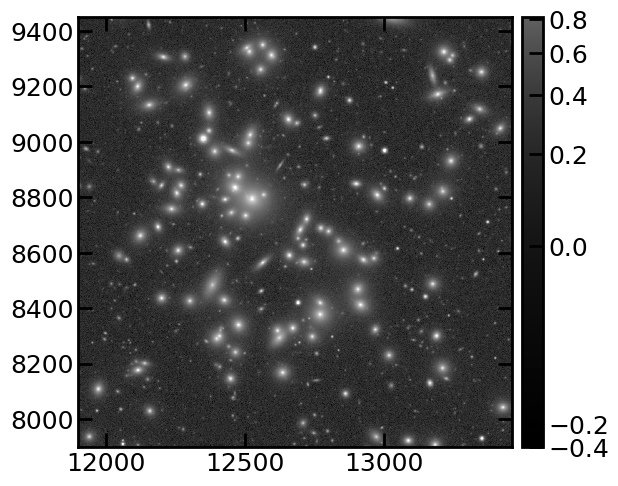

In [19]:
plotImage(ExposureF(sodaCutout))

> Figure 1: The `deepCoadd` cutout image, displayed in grayscale with a scale bar at right, and image axes in pixels. The field is centered on a rich galaxy cluster.

Alternatively, the cutout can be stored directly in memory without first writing to disk. This method is demonstrated in the below cell.

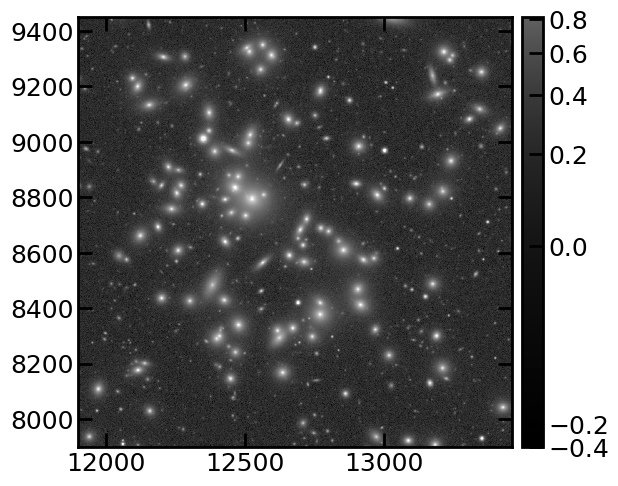

In [20]:
cutout_bytes = sq.execute_stream().read()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)

plotImage(exposure)

### 2.2.3 Using polygon to define the image cutout shape instead of a circle

It is also possible to define the cutout geometry using a polygon, which enables the cutout to be rectangular, but not necessarily be square. For this, use `polygon`, which takes as input the four corners in celestial coordinates. A minimum of 3 vertices are required (the line from the last vertex back to the first is implicit) Vertices must be ordered in the counter-clockwise direction. For example: a polygon is defined as a set of 4 (x,y) coordinates from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34) as:

POLYGON=12 34 14 34 14 36 12 36

Since the center of the galaxy cluster is already defined in RA and Dec in the cells above (`spherePoint`), this example will define each x,y set as RA+/-sphereRadius and Dec+/-sphereRadius. 

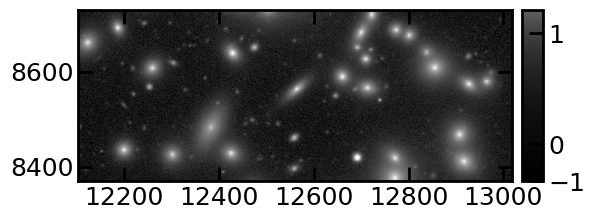

In [21]:
sq2 = SodaQuery.from_resource(dl_results,
                              dl_results.get_adhocservice_by_id("cutout-sync"),
                              session=auth_session)
sphereRadius1 = 0.03 * u.deg
sphereRadius2 = 0.01 * u.deg

sq2.polygon = (spherePoint.getRa().asDegrees() * u.deg - sphereRadius1,
               spherePoint.getDec().asDegrees() * u.deg - sphereRadius2,
               spherePoint.getRa().asDegrees() * u.deg - sphereRadius1,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius2,
               spherePoint.getRa().asDegrees() * u.deg + sphereRadius1,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius2)

sodaCutout2 = os.path.join(os.getenv('HOME'), tempdir + '/soda-cutout-polygon.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())

plotImage(ExposureF(sodaCutout2))

> Figure 2: A rectangular polygon cutout of the image displayed in Figure 1.

There is an important difference to note between the circle and polygon shape definitions. The angular distance on the sky that defines the circular cutout size already accounts for the difference in angular distance in the RA direction is smaller by a factor of cos(declination), where declination is in units radians. The difference increases with higher declination. However, the polygon definition does not automatically account for this cosine factor. Thus, circle and polygon cutout definitions using the same cutout edge length will not match size in the RA direction (for deepCoadds, the x-axis). The cell below demonstrates how to make this correction to the polygon cutout definition to create symmetric cutouts with polygon. Here sphereRadius comes from the circle definition above.

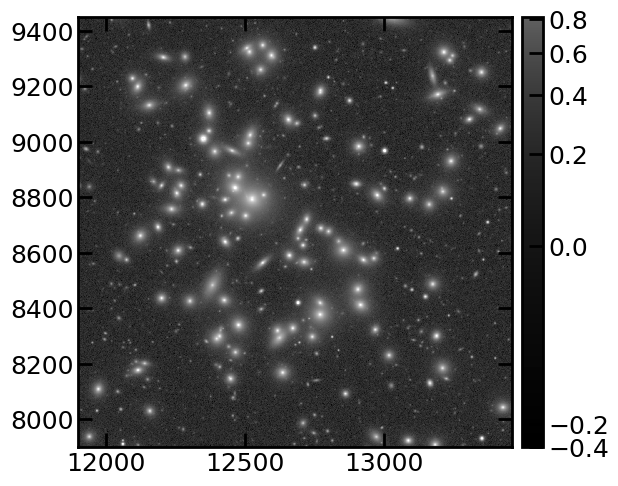

In [22]:
a = Angle(spherePoint.getDec().asDegrees(), u.deg)
cosd = np.cos(a.radian)

sq2.polygon = (spherePoint.getRa().asDegrees() * u.deg - sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg - sphereRadius,
               spherePoint.getRa().asDegrees() * u.deg - sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius,
               spherePoint.getRa().asDegrees() * u.deg + sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg + sphereRadius,
               spherePoint.getRa().asDegrees() * u.deg + sphereRadius/cosd,
               spherePoint.getDec().asDegrees() * u.deg - sphereRadius)

sodaCutout2 = os.path.join(os.getenv('HOME'), tempdir + '/soda-cutout_polygon.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())

plotImage(ExposureF(sodaCutout2))

> Figure 3: The same cutout as displayed in Figure 1, but using the `polygon` functionality and accounting for the $cos({\rm dec})$ term.

### 2.3 Test out the cutout wrapper function "make_image_cutout" 

All of the above steps from section 2.2 have been compiled in a wrapper function called `make_image_cutout` that is defined in Section 1. In the rest of this notebook, cutouts will be generated using this function for simplicity. As defined, it assumes the circular cutout definition demonstrated above. Thus, the function requires as input the TAP service, the center ra/dec of the cutout, the `dataId` and imtype (Section 4 will demonstrate how to do this for calexp, not just deepCoadd) and the size of the cutout (i.e. what was defined as `sphereRadius` above). The next cell demonstrates how to run all the steps by calling `make_image_cutout` and plotting the result.

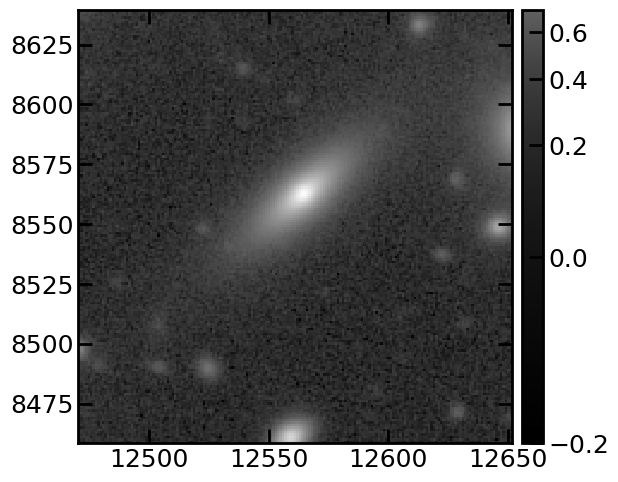

In [23]:
imtype = 'deepCoadd'
test = make_image_cutout(service, ra, dec, dataId=dataId,
                         imtype=imtype, cutout_size=0.005)
plotImage(ExposureF(test))

> Figure 4: A small image cutout, created using the `make_image_cutout` function.

## 3. Science application: validating a galaxy sample based on color-color selection 

This section will demonstrate a simple example of a science use-case for the Rubin Image Cutout Service. Lyman-break color selections are a common way to identify galaxies at high redshifts. The selections make use of the absorption by intergalactic hydrogen in the foreground of all galaxy light blueward of the Lyman limit (912A) or at very high redshifts, Lyman-alpha (1216A). <a href="http://candels-collaboration.blogspot.com/2012/08/how-to-find-distant-galaxies.html">More details about why this works can be found at this blog-post.</a> DP0.2 includes mock galaxies up to redshift (z) of 3, where the Lyman-break falls between the LSST u and g bands. Such galaxies can be identified by their very red u-g colors, and since intergalactic hydrogen absorbs all the light blueward of the Lyman break, true z~3 galaxies should be undetected in the LSST u-band. The cell below will perform a search for redshift of 3 galaxies as u-band dropouts, and will create cutouts in each of the LSST filters in order to visually inspect the Lyman-break galaxy (LBG) candidates to confirm the real candidates show no u-band flux. 

### 3.1 The u-band dropout LBG color selection
To search for $z\sim3$ LBGs in DP0.2, first define a u-band color selection based on the existing literature that uses filter sets similar to that of LSST. Below outlines the set of colors used in Steidel et al. 2003 (see also Boutsia et al 2014, among other references. Many selections exist, where changes to colors would alter the redshift selection function, or may differ due to differences in the broad band filter shapes of other instruments).

U − G >= (G − R) + 1.0

G − R <= 1.2


where capital letters U, G, and R indicate the total AB magnitudes in the LSST filters u, g, r. Since DP0.2 is only 5-year depth mock data in the LSST filters, our search will also include a g-band magnitude that is relatively bright (G < 24.5 ABmag) in order to obtain high-quality candidates. 

High redshift galaxies are typically small in size. For this exercise, use aperture photometry with a relatively small aperture diameter (9 pixels) in order to obtain high S/N measurements and exclude neighbors.

#### 3.1.1 Ammending a typical search because of the rarity of z~3 galaxies in the mock data.
The mock galaxies that go into DP0.2 are created using the LSST Catalog Simulator (<a href=https://www.lsst.org/scientists/simulations/catsimcatSim>catSim</a>), and are based on an empirical model of the evolution of galaxies outlined in <a href="https://arxiv.org/abs/1907.06530">Korytov et al. 2019</a>. The input model is based on realistic number densities, fluxes, and redshift distributions across cosmic time, and utilizes the UniverseMachine methodology to assign empirical properties (see <a href="https://arxiv.org/abs/1806.07893">Behroozi et al. 2019</a>). 

Typically at any redshift, bright galaxies are rarer than faint galaxies, which are much more common. And typically in any patch of the sky, nearby galaxies will be much more common above the detection limit of a survey than distant $z\sim3$ galaxies. This means that $z\sim3$ galaxies that are bright enough to meet the criteria we want (G$ < 24.5$) will require a large search area to identify a statistical sample. So, in this example, we will first identify a parent sample of bright (G < 24.5) galaxies over a very large area (4 degrees) to ensure the parent sample contains enough rare distant galaxies.



In [24]:
center_coords = "62, -37"
ralbg = 62.
declbg = -37.
radius = "4.0"
max_rec = 500000

query = "SELECT TOP " + str(max_rec) + " " + \
        "objectId, coord_ra, coord_dec, detect_isPrimary, patch, tract, " + \
        "u_ap09Flux, u_ap09FluxErr, " + \
        "scisql_nanojanskyToAbMag(u_ap09Flux) as umag, " + \
        "scisql_nanojanskyToAbMag(r_ap09Flux) as rmag, " + \
        "scisql_nanojanskyToAbMag(g_ap09Flux) as gmag, " + \
        "scisql_nanojanskyToAbMag(u_ap09FluxErr) as umagErr " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + center_coords + ", " + radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 AND detect_fromBlend = 0 " + \
        "AND g_ap09Flux/g_ap09FluxErr > 10 AND " + \
        "r_ap09Flux/r_ap09FluxErr > 10" + \
        "AND scisql_nanojanskyToAbMag(g_ap09Flux) < 24.5 "
print(query)

SELECT TOP 500000 objectId, coord_ra, coord_dec, detect_isPrimary, patch, tract, u_ap09Flux, u_ap09FluxErr, scisql_nanojanskyToAbMag(u_ap09Flux) as umag, scisql_nanojanskyToAbMag(r_ap09Flux) as rmag, scisql_nanojanskyToAbMag(g_ap09Flux) as gmag, scisql_nanojanskyToAbMag(u_ap09FluxErr) as umagErr FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 4.0)) = 1 AND detect_isPrimary = 1 AND detect_fromBlend = 0 AND g_ap09Flux/g_ap09FluxErr > 10 AND r_ap09Flux/r_ap09FluxErr > 10AND scisql_nanojanskyToAbMag(g_ap09Flux) < 24.5 


In [25]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [26]:
results = job.fetch_result()

In [27]:
results.to_table()

objectId,coord_ra,coord_dec,detect_isPrimary,patch,tract,u_ap09Flux,u_ap09FluxErr,umag,rmag,gmag,umagErr
,deg,deg,,,,nJy,nJy,,,,
int64,float64,float64,bool,int64,int64,float64,float64,float64,float64,float64,float64
1405791586809283127,60.4465925,-40.7900205,True,31,3261,1508.0021443,63.4881908,23.453995102304546,22.961225470604315,23.32954361724193,26.89326762170504
1405791586809283415,60.4246972,-40.7843474,True,31,3261,760.7822103,61.8075519,24.1968491281198,24.913913006128553,24.49577154007617,26.922396144473623
1405791586809282818,60.4006376,-40.7972744,True,31,3261,1476.2860402,63.2203233,23.477073717317484,23.580932298920914,23.501560295882523,26.897858218921932
1405791586809283990,60.2984402,-40.7713752,True,31,3261,2846.9143678,64.360151,22.764063989448417,22.906417459445777,22.72145475065328,26.87845736410538
1405791586809283722,60.3696682,-40.7772683,True,31,3261,133.4709868,60.5638809,26.08653282155474,22.691273650820435,24.107468744483263,26.944465758165094
1405791586809283670,60.3477601,-40.7786029,True,31,3261,1298.8083114,63.7849311,23.616137352194688,23.552849914329045,23.586751139618073,26.88820477314587
1405791586809283691,60.3588224,-40.7781139,True,31,3261,1203.5529866,62.5225055,23.698836962721572,22.19662856181774,23.130480076067993,26.909909066434523
1405791586809283829,60.3446909,-40.7752595,True,31,3261,576.8747835,62.832005,24.49729611154967,24.458121516389795,24.45087236993394,26.904547703784203


The next cells create a plot of the U-G vs G-R colors of the parent sample, and identify the high-redshift galaxy candidates based on the color selection discussed above. For sources with low S/N fluxes in u-band, we cannot robustly recover the U-G color, and instead we get a lower limit on how red it is (owing to the upper limit to the u-band flux). Thus, the U-G color can be overestimated if the u-band flux is not significant. Thus, sources with low S/N u-band flux will be reset to an error floor that corresponds the noise level of the u-band imaging so that it's color is not overestimated. To do this, define a new parameter called `umag` to store the u-band magnitude for assessing colors. In this case, if sources have signal to noise less than 1 in U_band, umag will instead hold the `umagErr` from the object table).

In [28]:
umag = np.zeros(len(results['umag']), dtype='float')
ubandS2N = np.asarray(results['u_ap09Flux'] / results['u_ap09FluxErr'], dtype='float')

for i in range(len(umag)):
    if ubandS2N[i] < 1:
        umag[i] = results['umagErr'][i]
    else:
        umag[i] = results['umag'][i]

Further, this simple example uses a restricted color selection that is more narrow and blue in G-R than typical selections (G-R$<$0.2; this may exclude real z=3 galaxies that are redder in G-R, for example galaxies that have older stars or are dusty; but the restriction is helpful for this simple example because it lowers the number of interloper sources). The LBG candidates (indexed from the array as `whlbg`) identified using the color selection (black dashed lines) are in orange, with the full query of all objects in blue.

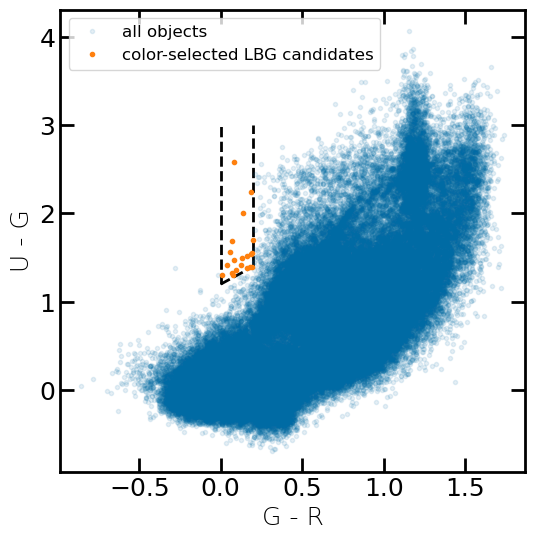

In [29]:
GRlim = 0.2
GRfloor = 1.2

whlbg = np.where(((umag-results['gmag'])
                  >= ((results['gmag'] - results['rmag']) + GRfloor))
                 & ((results['gmag'] - results['rmag']) < GRlim)
                 & ((results['gmag'] - results['rmag']) > 0))[0]

GmR = np.arange(0, GRlim + 0.01, 0.1)
plt.plot(GmR, GmR + GRfloor, '--', color='k')
plt.plot([0, 0], [GRfloor, 3], '--', color='k')
plt.plot([GRlim, GRlim], [GRlim + GRfloor, 3], '--', color='k')

GminusR = results['gmag']-results['rmag']
UminusG = umag-results['gmag']

plt.plot(GminusR, UminusG, '.', label='all objects', alpha=.1)
plt.plot(GminusR[whlbg], UminusG[whlbg], '.',
         label='color-selected LBG candidates')

plt.xlabel('G - R')
plt.ylabel('U - G')
plt.legend()
plt.show()

> Figure 5: The $g-r$ versus $u-g$ color of all objects (blue) and color-selected LBG candidates (orange), with the box defining LBG candidates marked with black dashed lines.

Some fraction of the orange LBG candidates might be interlopers. The two next cells below will plot image cutouts of each LBG candidate for visual inspection. Since this is a simulated dataset, the first cell performs `query3` to the TAP service to pull the intrinsic redshift `ts_redshift` for each object from the truth table. This will be used to compare with the expected redshift $z\sim3$ of selected objects in the image cutout captions (see DP0.2 Tutorial Notebook 08 for more information on truth tables).

To limit the compute time (dominnated by creating the cutouts), select just the first 5 galaxy candidates among the sample. This number can be altered using `n_plot`. 

In [30]:
n_plot = 5

id = str(tuple(list(results['objectId'][whlbg][0:n_plot])))

query3 = "SELECT mt.id_truth_type AS mt_id_truth_type, " + \
         "obj.objectId AS obj_objectId,  " + \
         "ts.redshift AS ts_redshift " + \
         "FROM dp02_dc2_catalogs.MatchesTruth AS mt " + \
         "JOIN dp02_dc2_catalogs.TruthSummary AS ts " + \
         "ON mt.id_truth_type=ts.id_truth_type " + \
         "JOIN dp02_dc2_catalogs.Object AS obj " + \
         "ON mt.match_objectId=obj.objectId " + \
         "WHERE obj.objectId IN "+id+" " + \
         "AND ts.truth_type=1 " + \
         "AND obj.detect_isPrimary=1 "

results3 = service.search(query3)
results3.to_table()


mt_id_truth_type,obj_objectId,ts_redshift
str18,int64,float32
8018606732_1,1652143764082266858,2.82676
9706148291_1,1486284634055516057,2.83135
7957016481_1,1651281746966086683,2.90632
8769504807_1,1566804069580805500,2.91797
8956980301_1,1568580880371288852,2.91471


The cell below actually creates the cutouts for each of the objects in 5 different bands. By inspecting the cutouts and intrinsic redshift, there are a small number of interlopers (at redshifts $z<2.5$ or so) which visibly show some u-band flux.

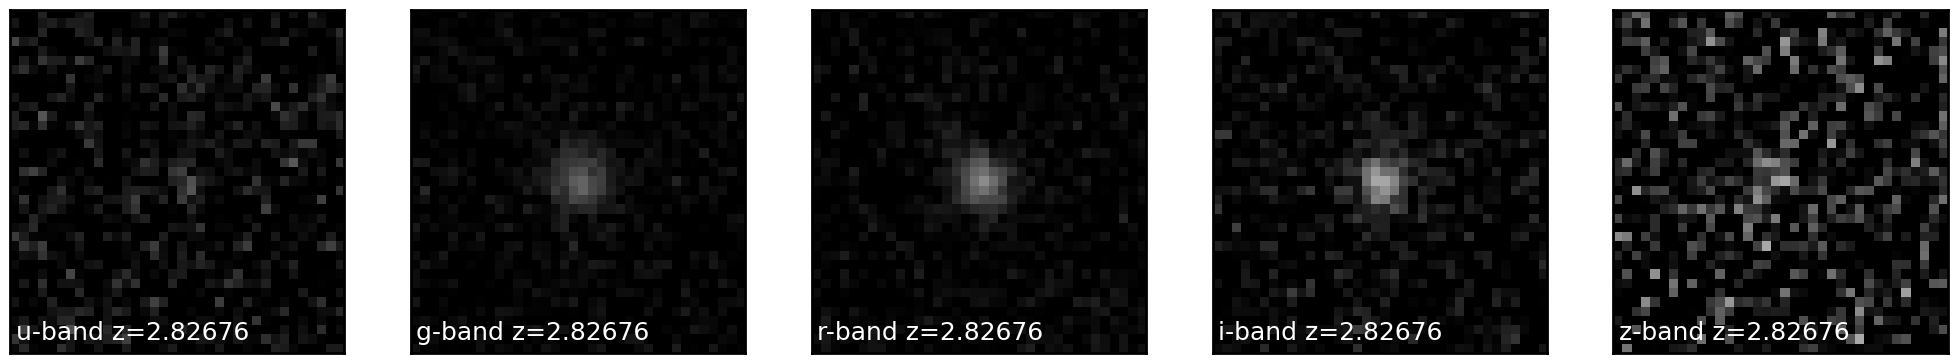

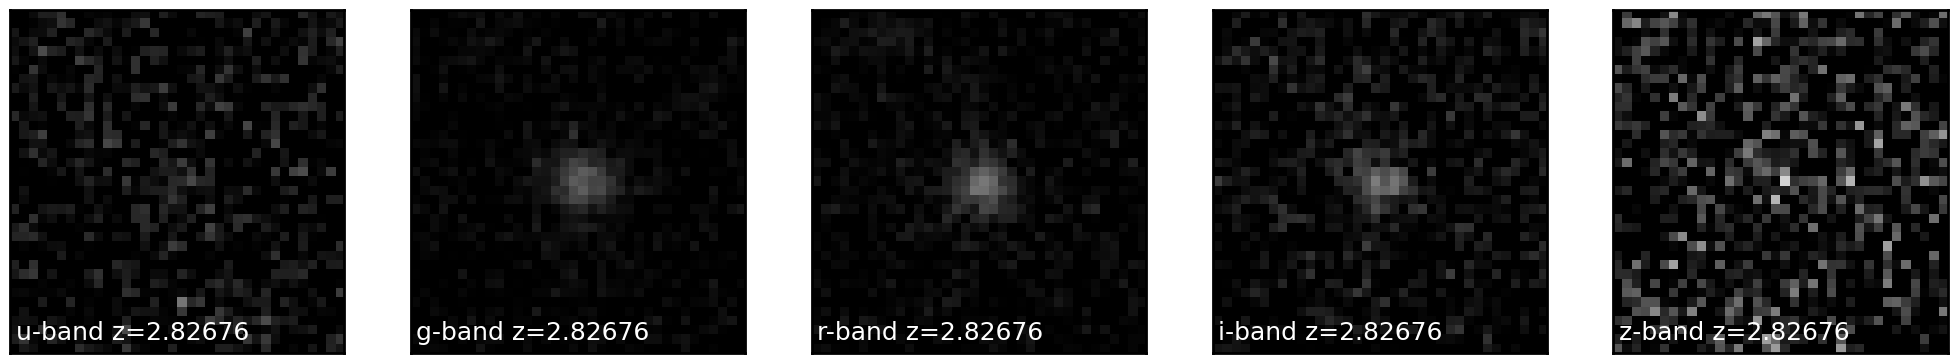

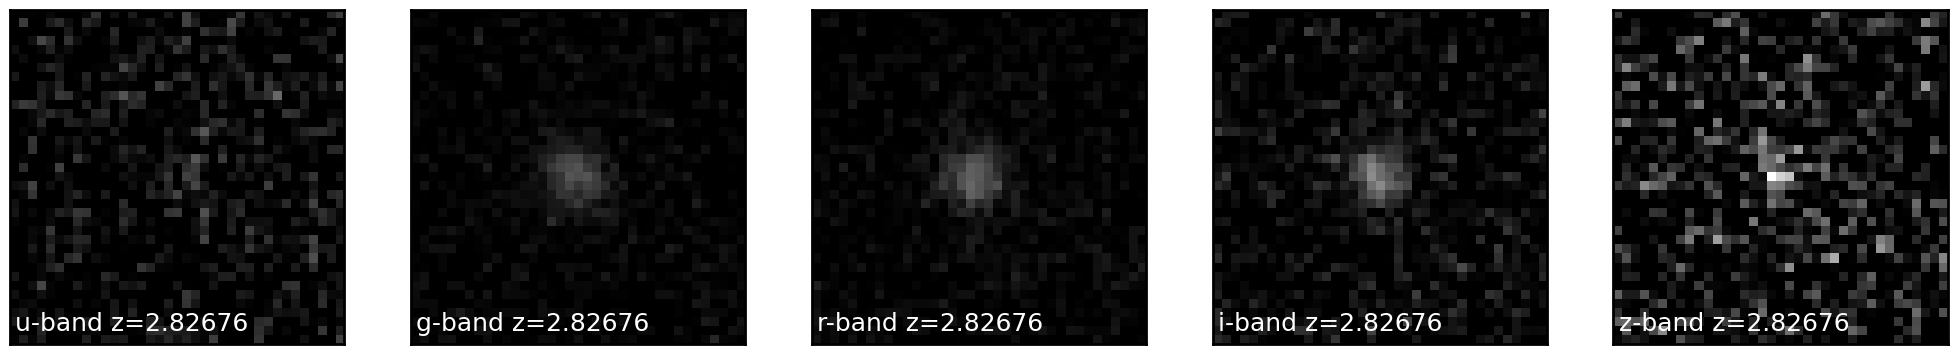

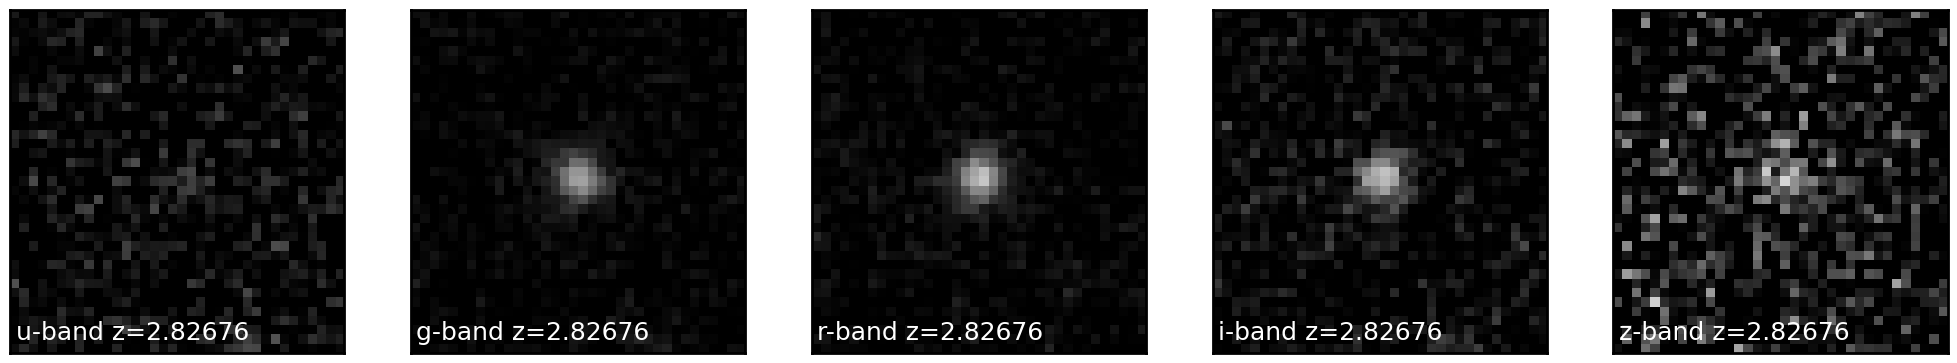

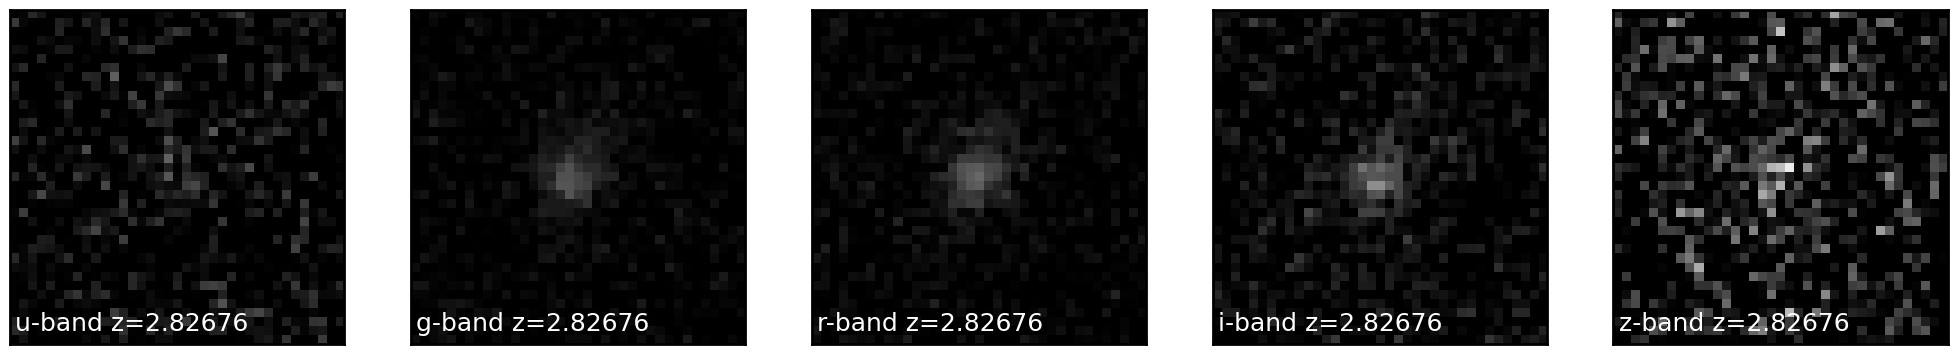

In [31]:
filt = ["u", "g", "r", "i", "z"]

for i in range(n_plot):
    fig, axs = plt.subplots(1, len(filt), figsize=(25, 25))


    for j, ax in enumerate(fig.axes):
        dataId_deep = {'patch': results['patch'][whlbg][i],
                       'tract': results['tract'][whlbg][i],
                       'band': filt[j]}
        cutout = make_image_cutout(service, results['coord_ra'][whlbg][i],
                                   results['coord_dec'][whlbg][i],
                                   cutout_size=0.001, imtype='deepCoadd',
                                   dataId=dataId_deep,
                                   filename='cutout_' + filt[j] +
                                   '_' + str(i) + '.fits')


        hdulist = fits.open(cutout)
        img_hdr = hdulist[1].header
        img_wcs = WCS(img_hdr)
        img_data = fits.getdata(cutout)
        ax.imshow(img_data, cmap='gray',
                  vmin=0, vmax=0.7, norm='linear',
                  origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(.1, .9, filt[j]+'-band z=' + str(results3['ts_redshift'][0]),
                color='white')


> Figure 6: Cutout images in $ugriz$ bands (left to right) for 5 of the LBG candidates (top to bottom).

## 4. Creating calexp cutouts to inspect changing flux for the diaObject

Another useful application of the cutout tool is to visually inspect a large number of images of a source identified with difference image analysis (DIA) in order to confirm its variability. 

This example is different in that it requires generating cutouts of calexp files around the time the transient is identified, rather than the deepCoadds as used above. 

### 4.1 Query for the source information needed to plot images before and after the transient event

This example will use a known diaObject with ID 1250953961339360185 (one identified and studied in DP0.2 tutorial notebook 07a). The cell below will retrieve the information needed to generate a set of images in order of time, including and after the transient event. The TAP query will identify 8 diaSource IDs measured for this diaObject at the ra/dec, and will also retrieve the ccdVisitId of each time the diaSource was observed in a calexp image.  

The last line will sort the query return by date, so that they appear in the correct chronological order.

In [32]:
diaObjectId = 1250953961339360185
query =  "SELECT ra, decl, diaObjectId, diaSourceId, "\
         "psFlux, psFluxErr, filterName, midPointTai, "\
         "SNR, ccdVisitId, "\
         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "\
         "FROM dp02_dc2_catalogs.DiaSource "\
         "WHERE diaObjectId = " + str(diaObjectId)\
         + " AND filterName = 'i' "\
         "ORDER BY midPointTai"
print(query)

SELECT ra, decl, diaObjectId, diaSourceId, psFlux, psFluxErr, filterName, midPointTai, SNR, ccdVisitId, scisql_nanojanskyToAbMag(psFlux) AS psAbMag FROM dp02_dc2_catalogs.DiaSource WHERE diaObjectId = 1250953961339360185 AND filterName = 'i' ORDER BY midPointTai


In [33]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [34]:
diaSrc = job.fetch_result().to_table()

The next cell will retrieve calexp cutouts for each of the dia sources in the query, and plot them. Vmin and vmax set a common scaling so that the image scale is not skewed by a bright neighbor, and emphasizes the lower brightness sources such as the dia source. Each figure also is labeled by the time since the first difference image ($\Delta$t in units MJD).

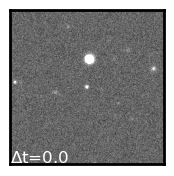

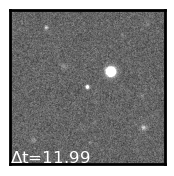

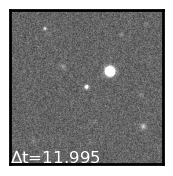

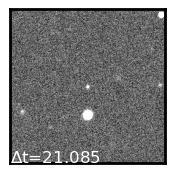

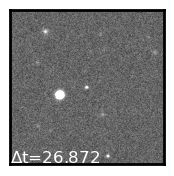

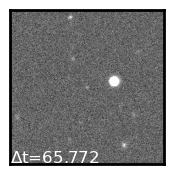

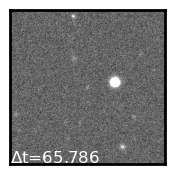

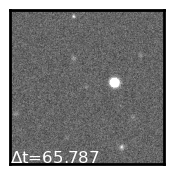

In [35]:
%matplotlib inline

ra = diaSrc['ra'][0] 
dec = diaSrc['decl'][0]
vmin = -200
vmax = 300    
i=0
for src in diaSrc:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)

    dataId_calexp = {'visit':visit, 'detector':detector}
    test = make_image_cutout(service, ra, dec, cutout_size=0.007,
                             imtype='calexp', dataId=dataId_calexp,
                             filename='cutout_'+str(i)+'.fits')

    ref_fitsname = 'cutout_'+str(i)+'.fits'
    image_file = os.path.join(os.getenv('HOME'), tempdir + '/' + ref_fitsname)

    fig, ax1 = plt.subplots(1,1,figsize=(2, 2))

    hdulist = fits.open(image_file)
    img_hdr = hdulist[1].header
    img_wcs = WCS(img_hdr)
    img_data = fits.getdata(image_file)
    ax1.imshow(img_data, cmap='gray', 
               vmin=vmin, vmax=vmax,
               origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(.1, .9,'$\Delta$t=' + str(round(src['midPointTai']-diaSrc['midPointTai'][0],3)),
                color='white',fontsize=12)
    plt.show()
    i = i+1

> Figure 7: The eight individual $i$-band cutout images for the `diaObject`.

### 4.2 Align the calexp images of the transient

In the above plots, it is clear that the calexp image orientations are not aligned with each other, because the calexp images are not necessarily all taken in the same position angle on the sky. The cell below will go through each dia source, identify the calexp file in which it was identified, and create cutouts (as above) except now they will all be aligned with each other. At the same time as creating these new aligned fits files for each cutout, the cell will create png files that will be useful for visualizing the transient behavior (to be used in Section 4.3).

The `cutout_size` variable is in units of degrees, converted from `cutout_size_pix` using the LSST Science Camera platescale of 0.2 arcseconds per pixel.

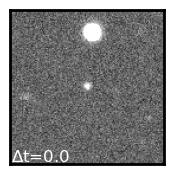

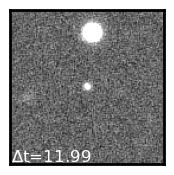

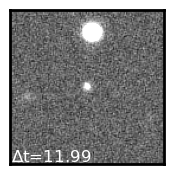

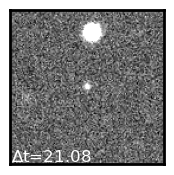

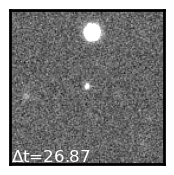

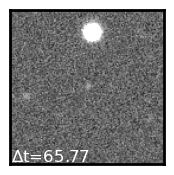

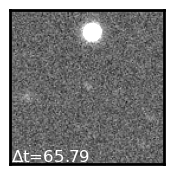

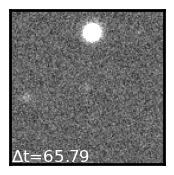

In [36]:
i = 0
cutout_size_pix = 131
cutout_size = cutout_size_pix * 0.2 / 3600.0

for src in diaSrc:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)
    dataId_calexp = {'visit': visit, 'detector': detector}
    if i == 0:

        # Make the first image the reference image, that all the
        # others images will be warped to align with.
        ref_fitsname = 'cutout_ref.fits'
        ref_cutout = os.path.join(os.getenv('HOME'), tempdir + '/' + ref_fitsname)

        make_image_cutout(service, ra, dec, cutout_size=cutout_size,
                          imtype='calexp', dataId=dataId_calexp,
                          filename=ref_fitsname)

        img_ref = ExposureF(ref_cutout)
        minmax = get_minmax_xy(img_ref, cutout_size_pix)
        im_arr = img_ref.image.array[minmax['minx']: minmax['maxx'],
                                     minmax['miny']: minmax['maxy']]

        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        ax.text(.1, .9, r'$\Delta$t='
                + str(round(src['midPointTai']-diaSrc['midPointTai'][0], 2)),
                color='white', fontsize=12)

        figname = os.path.join(os.getenv('HOME'),
                               tempdir + '/cutout_' + str(i) + '.png')
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.show()
        plt.close()

    else:

        fitsname = 'cutout_'+str(i)+'.fits'
        make_image_cutout(service, ra, dec, cutout_size=cutout_size,
                          imtype='calexp', dataId=dataId_calexp,
                          filename=fitsname)

        img_cutout = os.path.join(os.getenv('HOME'), tempdir + '/'+fitsname)
        img = ExposureF(img_cutout)

        img_warped = warp_img(img_ref, img, img_ref.getWcs(), img.getWcs())

        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

        minmax = get_minmax_xy(img_warped, cutout_size_pix)
        im_arr = img_warped.image.array[minmax['minx']: minmax['maxx'],
                                        minmax['miny']: minmax['maxy']]

        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(.1, .9, r'$\Delta$t='
                + str(round(src['midPointTai']-diaSrc['midPointTai'][0], 2)),
                color='white', fontsize=12)

        figname = os.path.join(os.getenv('HOME'),
                               tempdir + '/cutout_' + str(i) + '.png')
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.show()
        plt.close()
    i += 1

> Figure 8: Similar to Figure 7, but for a smaller cutout size and aligning all of the cutout images.

### 4.3 Make a gif of the aligned calexp cutouts for the transient

The cell below will take all the png files created above in the temp folder, and make a gif movie that demonstrates the transient behavior of the diaobject. The gif is by default stored in the same directory as the images it is generated from.

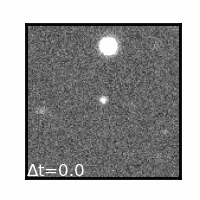

In [37]:
images = os.path.join(os.getenv('HOME'), tempdir + '/')
make_gif(images)

display(dimg(data=open(images+'animation.gif', 'rb').read()))

## 5. Remove the temp folder

As mentioned in Section 1.2, empty and remove the temporary folder in the home directory.
This will remove all files generated by this notebook, and leave the folder empty.

To remove the temp folder, open a terminal and type `cd ~` to go to the home directory, then `rmdir dp02_13a_temp` to remove the folder.

In [38]:
for filepath in glob.glob(os.path.join(os.getenv('HOME'), tempdir + '/')+"*"):
    os.remove(filepath)

## 6. Exercises for the learner

1) Extend the time baseline for the cutouts of the DIA object prior to the transient detection (hint, use the ForcedSourceOnDiaObject table)
2) Test the failure modes of the cutout tool: what happens if a cutout is requested around coordinates that do not lie inside the linked image?